# Setup

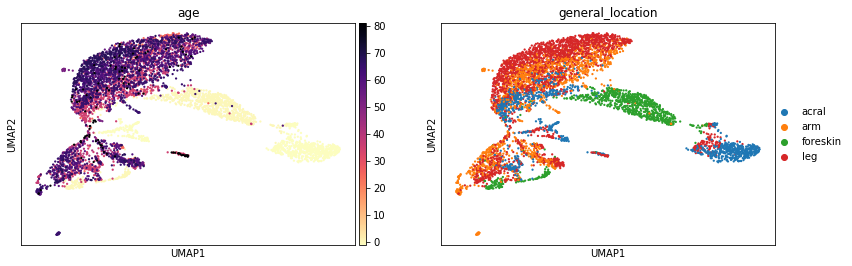

... storing 'noise_group' as categorical


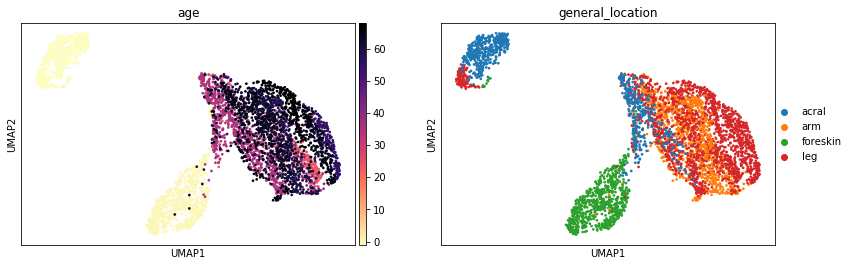

Completed


In [1]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.display import display, HTML

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


# Pearson's correlation

4283
2801
2801


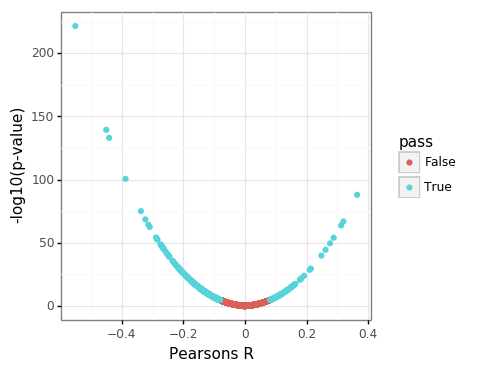

<ggplot: (-9223363280136828591)>


,gene,R,pval,R2,neglog10_pval
8121,SERPINF1,-0.551075,2.781946e-222,0.303684,221.555651
3760,IGFBP3,-0.450589,3.906909e-140,0.203030,139.408167
2736,FBLN1,-0.441269,8.076811e-134,0.194718,133.092760
7426,PTGDS,-0.388014,2.591282e-101,0.150555,100.586485
4317,LGALS3,0.364452,9.902740e-89,0.132826,88.004245
1297,CCND1,-0.338011,8.110974e-76,0.114252,75.090927
2270,DUSP1,-0.323584,2.770099e-69,0.104707,68.557505
6246,NDRG2,0.319845,1.199057e-67,0.102301,66.921160
1944,CYR61,-0.313773,4.857232e-65,0.098453,64.313611
6054,MT2A,0.312472,1.725828e-64,0.097639,63.763003


querying 1-20...done.
Finished.
1 input query terms found no hit:
	['CYR61']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0: SERPINF1
This gene encodes a member of the serpin family that does not display the serine protease inhibitory activity shown by many of the other serpin proteins. The encoded protein is secreted and strongly inhibits angiogenesis. In addition, this protein is a neurotrophic factor involved in neuronal differentiation in retinoblastoma cells. Mutations in this gene were found in individuals with osteogenesis imperfecta, type VI. [provided by RefSeq, Aug 2016].
1: IGFBP3
This gene is a member of the insulin-like growth factor binding protein (IGFBP) family and encodes a protein with an IGFBP domain and a thyroglobulin type-I domain. The protein forms a ternary complex with insulin-like growth factor acid-labile subunit (IGFALS) and either insulin-like growth factor (IGF) I or II. In this form, it circulates in the plasma, prol

In [2]:
###############################################
###############################################
# Correlation between expression and true age
# Returns correlation statistics and gene function annotation
###############################################
###############################################

# Specify number of genes to print from top of list sorted on R2
topn = 20

# Specify whether to use all samples or only adult samples in correlation
adults_only = False

# Specify whether to remove acral general_location
exclude_acral = True

# Specify whether to remove foreskin general_location
exclude_foreskin = True

###############################################

ref = 'age'
input_adata = adata_subset2
print(len(input_adata))
exclusion_list = []
if exclude_foreskin == True:
    exclusion_list = exclusion_list + ['foreskin']
if exclude_acral == True:
    exclusion_list = exclusion_list + ['acral']
input_adata = input_adata[[x not in exclusion_list for x in input_adata.obs.general_location]]
print(len(input_adata))

if adults_only == True:
    input_adata = input_adata[input_adata.obs.age > 0]
print(len(input_adata))

corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
for col in df.columns.tolist():
    r, pval = pearsonr(df[ref], df[col])
    r_list.append(r)
    p_list.append(pval)
    gene_list.append(col)
out_df = pd.DataFrame({'gene':gene_list,
                       'R':r_list, 
                       'pval':p_list})
out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
out_df['R2'] = out_df['R']**2 
out_df = out_df.sort_values('R2', ascending=False)
out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
out_df['neglog10_pval'] = -np.log10(out_df['pval'])
out_df['pass'] = out_df.neglog10_pval > -np.log10(0.05/len(df))

# plot R vs p-value
plotnine.options.figure_size=(4,4)
print(ggplot(out_df)
          +theme_bw()
          +geom_point(aes('R','neglog10_pval', color = 'pass'))
          +labs(x='Pearsons R', y='-log10(p-value)'))

# print correlation scores table
display(out_df.drop('pass', axis = 1).head(topn))

# search correlation df
gene = out_df.gene[:topn]
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]

In [ ]:
###############################################
###############################################
# Single-gene expression statistics
# Returns single-gene expression statistics as a function of true age
###############################################
###############################################

# Specify gene symbol
gene = 'NGFR'

# Specify age-binning: 'age_group' = 30-yr bins, 'age_bin' = 10-yr bins
groupby='age_bin'

###############################################

# true age
print('true age vs. log expression')
true_age_exp(gene, input_adata)

# n_genes
print('n_genes and age vs. log expression')
cat, plot_df = prepare_dataframe(input_adata,
                            gene,
                            groupby)
plot_df = plot_df.reset_index().drop([groupby], axis = 1)
plot_df['age'] = input_adata.obs.age.values
plot_df['n_genes']  = input_adata.obs.n_genes.values

plotnine.options.figure_size = (3,3)
print(ggplot(plot_df)
     + theme_bw()
     + theme(axis_text_x = element_text(angle = 90))
     + geom_point(aes('n_genes', gene))
     + labs(y = f'{gene} log expression')
     )

stat,pval = stats.spearmanr(plot_df.n_genes.values, plot_df[gene].values)
R2 = stat**2
print(f'Spearmans rho2: {R2} (p-value = {pval})')

print(ggplot(plot_df)
     + theme_bw()
     + theme(axis_text_x = element_text(angle = 90))
     + geom_point(aes('age', gene))
     + labs(y = f'{gene} log expression')
     )

stat,pval = stats.spearmanr(plot_df.age.values, plot_df[gene].values)
R2 = stat**2
print(f'Spearmans rho2: {R2} (p-value = {pval})')

# binned age
print('binned_age vs. log expression and percent expressing')
gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby], cmap='magma_r')
sc.pl.umap(full_adata, color=[gene, groupby], cmap='magma_r')

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


# Spearman's correlation

4283
2801
2684


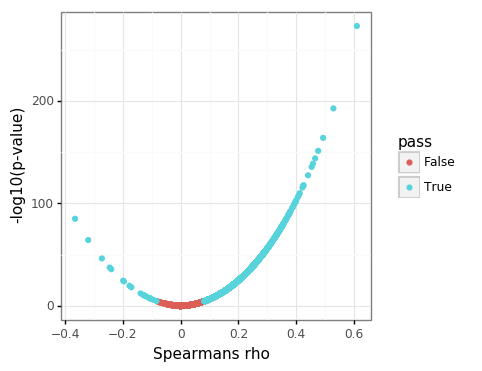

<ggplot: (-9223363242860381685)>


,gene,rho,pval,neglog10_pval
7110,PMEL,0.610262,1.191904e-273,272.923759
9661,TYRP1,0.528877,2.400338e-193,192.619728
7659,RETSAT,0.493287,1.276587e-164,163.893949
5939,MMP17,0.476138,6.005968e-152,151.221417
1146,CAPG,0.465802,1.186564e-144,143.925709
9659,TYR,0.458050,2.422966e-139,138.615653
1914,CYGB,0.453562,2.490381e-136,135.603734
2437,EMP1,0.441025,3.751481e-128,127.425797
3230,GPAT4,0.425540,1.629350e-118,117.787986
5930,MLPH,0.424524,6.706001e-118,117.173536


querying 1-20...done.
Finished.
0: PMEL
This gene encodes a melanocyte-specific type I transmembrane glycoprotein. The encoded protein is enriched in melanosomes, which are the melanin-producing organelles in melanocytes, and plays an essential role in the structural organization of premelanosomes. This protein is involved in generating internal matrix fibers that define the transition from Stage I to Stage II melanosomes. This protein undergoes a complex pattern of prosttranslational processing and modification that is essential to the proper functioning of the protein. A secreted form of this protein that is released by proteolytic ectodomain shedding may be used as a melanoma-specific serum marker. Alternate splicing results in multiple transcript variants. [provided by RefSeq, Jan 2011].
1: TYRP1
This gene encodes a melanosomal enzyme that belongs to the tyrosinase family and plays an important role in the melanin biosynthetic pathway. Defects in this gene are the cause of rufous o

In [155]:
# Spearman's rho #

###############################################
###############################################
# Correlation between expression and true age
# Returns correlation statistics and gene function annotation
###############################################
###############################################

# Specify number of genes to print from top of list sorted on R2
topn = 20

# Specify whether to use all samples or only adult samples in correlation
adults_only = True

# Specify whether to remove acral general_location
exclude_acral = True

# Specify whether to remove foreskin general_location
exclude_foreskin = True

###############################################

ref = 'age'
input_adata = adata_subset2
print(len(input_adata))
exclusion_list = []
if exclude_foreskin == True:
    exclusion_list = exclusion_list + ['foreskin']
if exclude_acral == True:
    exclusion_list = exclusion_list + ['acral']
input_adata = input_adata[[x not in exclusion_list for x in input_adata.obs.general_location]]
print(len(input_adata))

if adults_only == True:
    input_adata = input_adata[input_adata.obs.age > 0]
print(len(input_adata))

corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
for col in df.columns.tolist():
    r, pval = stats.spearmanr(df[ref], df[col])
    r_list.append(r)
    p_list.append(pval)
    gene_list.append(col)
out_df = pd.DataFrame({'gene':gene_list,
                       'rho':r_list, 
                       'pval':p_list})
out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
out_df = out_df.sort_values('pval', ascending=True)
out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
out_df['neglog10_pval'] = -np.log10(out_df['pval'])
out_df['pass'] = out_df.neglog10_pval > -np.log10(0.05/len(df))

# plot R vs p-value
plotnine.options.figure_size=(4,4)
print(ggplot(out_df)
          +theme_bw()
          +geom_point(aes('rho','neglog10_pval', color = 'pass'))
          +labs(x='Spearmans rho', y='-log10(p-value)'))

# print correlation scores table
display(out_df.drop('pass', axis = 1).head(topn))

# search correlation df
gene = out_df.gene[:topn]
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]